In [1]:
import pandas as pd
import sqlite3
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [2]:
images_df = pd.read_csv('existing_images.csv')
images_df.head()

filename  face_width  face_height  \
0  faces_downloaded_categorized/7m-8q_ruki_na_kla...      1800.0       1800.0   
1  faces_downloaded_categorized/7m-8q_RTEmagicP_G...      2719.0       2719.0   
2  faces_downloaded_categorized/7m-8q_Jean-Noel_B...         0.0          0.0   
3    faces_downloaded_categorized/7m-8q_IMG_9082.JPG       702.0        702.0   
4      faces_downloaded_categorized/7m-8q_169_99.jpg         0.0          0.0   

   face_x  face_y   width  height  
0  1074.0  1257.0  4147.0  5000.0  
1   255.0   755.0  3239.0  4477.0  
2     0.0     0.0     0.0     0.0  
3   499.0   230.0  1600.0  1200.0  
4     0.0     0.0     0.0     0.0

In [3]:
markup_df = pd.read_csv('existing_markup.csv')
markup_df.head()

tag gender  age    emotion  left_eye_x  left_eye_y  right_eye_x  \
0  NaN      m   43  surprised        1545        1625         2495   
1  NaN      m   43  surprised         814        1759         2722   
2  NaN      m   43  surprised        2173         950         2996   
3  NaN      m   43  surprised         679         568         1023   
4  NaN      m   43  surprised        1181         638         2324   

   right_eye_y  mouth_lx  mouth_ly  mouth_rx  mouth_ry  nose_x  nose_y  \
0         1670      1835      2565      2175      2560    2010    2110   
1         1884      1092      3277      2216      3344    1723    2614   
2         1029      2253      1772      2764      1835    2585    1327   
3          480       811       841      1005       781     836     670   
4          738      1308      1594      1935      1649    1670    1143   

                                            image_fn   race age_range  
0  faces_downloaded_categorized/7m-8q_ruki_na_kla...  white       NaN  
1  faces_downloaded_categorized/7m-8q_RTEmagicP_G...  white       NaN  
2  faces_downloaded_categorized/7m-8q_Jean-Noel_B...  white       NaN  
3    faces_downloaded_categorized/7m-8q_IMG_9082.JPG  white       NaN  
4      faces_downloaded_categorized/7m-8q_169_99.jpg  white       NaN

In [4]:
detected_df = images_df[images_df.face_width > 0]
print 100.0 * len(detected_df) / len(images_df)

81.393550881


In [5]:
cascade_paths = [
    '/opt/local/share/OpenCV/haarcascades/haarcascade_frontalface_alt_tree.xml',
    '/opt/local/share/OpenCV/haarcascades/haarcascade_frontalface_alt2.xml',
    '/opt/local/share/OpenCV/haarcascades/haarcascade_frontalface_alt.xml',
    '/opt/local/share/OpenCV/haarcascades/haarcascade_frontalface_default.xml']
cascade_classifiers = []
for cascade_path in cascade_paths:
    cascade_classifier = cv2.CascadeClassifier(cascade_path)
    if cascade_classifier.empty():
        raise Exception("cascade_classifier.empty()")
    cascade_classifiers.append(cascade_classifier)

In [6]:
def detect_faces_in_img(img): 
    faces = []
    minSize = int(min(img.shape[0], img.shape[1]) * 0.1)
    for classifier in cascade_classifiers:
        faces = classifier.detectMultiScale(img, 1.05, 3, 0, (minSize, minSize))
        if len(faces) > 0:
            break
    return faces

def detect_faces_in_path(path):
    path = os.path.abspath(path)
    if not os.path.isfile(path):
        return None, None
    img = cv2.imread(path)
    if img is None:
        return None, None
    return detect_faces_in_img(img), img

def detect_faces_in_sample(sample):
    path = '../images/' + sample['filename']
    return detect_faces_in_path(path)

landmarks_names = ['left_eye_x', 'left_eye_y', 
                   'right_eye_x', 'right_eye_y', 
                   'mouth_lx', 'mouth_ly', 
                   'mouth_rx', 'mouth_ry', 
                   'nose_x', 'nose_y']

def get_best_face_in_sample(sample, biggest=True):
    faces, img = detect_faces_in_sample(sample)
    if faces is None or len(faces) == 0:
        return faces, img
    faces = sorted(faces, key=lambda x: x[2] * x[3], reverse=biggest)
    mrk_sample = markup_df[markup_df.image_fn == sample['filename']]
    landmarks = mrk_sample[landmarks_names].values[0]
    best_face = []
    for face in faces:
        x1, y1, w, h = face
        x2 = x1 + w
        y2 = y1 + h
        outside = False
        for i in xrange(0, len(landmarks), 2):
            px = landmarks[i]
            py = landmarks[i + 1]
            if px < x1 or px > x2 or py < y1 or py > y2:
                outside = True
                break
        if not outside:
            best_face = face
            break
    return face, img

[1102  914 1834 1834]


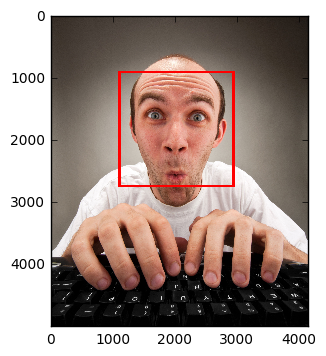

In [7]:
sample_index = 0
sample = images_df.ix[sample_index]
face, img = get_best_face_in_sample(sample)
print face
if not face is None and len(face) != 0:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x, y, w, h = face
    stroke = int(min(img.shape[0], img.shape[1]) * 0.01)
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), stroke)
    plt.imshow(img)

In [8]:
bad_imgs = []
for i, sample in images_df.iterrows():
    face, img = get_best_face_in_sample(sample)
    if face is None or len(face) == 0:
        bad_imgs.append(i)
    else:
        images_df.ix[i] = {'filename': sample['filename'],
                         'face_width': face[2],
                         'face_height': face[3],
                         'face_x': face[0],
                         'face_y': face[1],
                         'width': img.shape[1],
                         'height': img.shape[0]}
    checked = i + 1
    if checked % 100 == 0:
        print '%d samples checked: %d bad images found (%f%%)' % (checked, len(bad_imgs), 100.0 * len(bad_imgs) / checked)
print 'Finally: %d bad images found (%f%%)' % (len(bad_imgs), 100.0 * len(bad_imgs) / len(images_df))

100 samples checked: 6 bad images found (6.000000%)
200 samples checked: 6 bad images found (3.000000%)
300 samples checked: 7 bad images found (2.333333%)
400 samples checked: 7 bad images found (1.750000%)
500 samples checked: 7 bad images found (1.400000%)
600 samples checked: 17 bad images found (2.833333%)
700 samples checked: 42 bad images found (6.000000%)
800 samples checked: 76 bad images found (9.500000%)
900 samples checked: 108 bad images found (12.000000%)
1000 samples checked: 132 bad images found (13.200000%)
1100 samples checked: 162 bad images found (14.727273%)
1200 samples checked: 193 bad images found (16.083333%)
1300 samples checked: 217 bad images found (16.692308%)
1400 samples checked: 223 bad images found (15.928571%)
1500 samples checked: 227 bad images found (15.133333%)
1600 samples checked: 239 bad images found (14.937500%)
1700 samples checked: 247 bad images found (14.529412%)
1800 samples checked: 258 bad images found (14.333333%)
1900 samples checked: 

In [9]:
bad_images_df = images_df.ix[bad_imgs]
bad_paths = bad_images_df.filename.tolist()
bad_mrks = []
for i, sample in markup_df.iterrows():
    if sample['image_fn'] in bad_paths:
        bad_mrks.append(i)
bad_markup_df = markup_df.ix[bad_mrks]

In [10]:
good_images_df = images_df.drop(bad_imgs)
good_markup_df = markup_df.drop(bad_mrks)

In [11]:
good_images_df.to_csv('good_images.csv', index=False)
good_markup_df.to_csv('good_markup.csv', index=False)